# Simulating Asset Price Evolutions and Reprice Risky up-and-out Call Option

## Introduction

The model we implement in this assignment is the LIBOR forward rate model to simulate interest rates. The initial values for the LIBOR forward rates need to be calibrated to the market forward rates which can be deduced through the market zero-coupon bond prices. This continuously compounded interest rate is given by,

$$e^{r_{ti}(t_{i+1}-t_{i})} = 1 + L(t_{i},t_{i+1})(t_{i+1}-t_{i})$$

We initialize most variables as given by the question.

- Option maturity is one year <br>
- The option is struck at-the-money <br>
- The up-and-out barrier for the option is USD 150<br>
- The current share price is USD 100<br>
- The current firm value for the counterparty is USD 200<br>
- The counterparty’s debt, due in one year, is USD 175<br>
- The correlation between the counterparty and the stock is constant at 0.2 <br>
- The recovery rate with the counterparty is 25% 

## 1. LIBOR Forward Rates, Stock Paths, and Counterparty Firm Values

In this part, we use a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and counterparty firm values. We assume that the counterparty firm and stock values are uncorrelated with LIBOR forward rates.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import scipy.optimize

import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Initialize problem parameters
T = 1 # option maturity
L = 150 # up-and-out barrier
S0 = 100 # current share price
K = 100 # strike price, at-the-money


v_0 = 200 # counterparty firm current value
debt = 175 # counterparty's debt, due in one year 
corr = .2 # correlation
recovery_rate = 0.25 # recovery rate
########

corr_matrix = np.array([[1, corr], [corr, 1]])
sample_size = 100000

In [3]:
sigma_const = 0.30
gamma = 0.75

### Calibrate LIBOR forward rate model from zero coupon bond prices

We initialize the given zero-coupon bond prices:

In [4]:
# which gives monthly time intervals
t = np.linspace(0,1,13) 

market_zcb_prices = np.array([1.0, 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 0.9516,
       0.9457, 0.9399, 0.9342, 0.9285])

We next create functions to calculate the simulated bond prices from the Vasicek model (as well as helper functions A and D). We also define function F which is the differences between the bond prices calculated by our model and actual market zero-coupon bond prices :

In [5]:
def A(t1, t2, alpha):
    return (1 - np.exp(-alpha*(t2-t1)))/alpha

def D(t1, t2, alpha, b, sigma):
    val1 = (t2 - t1 - A(t1,t2,alpha)) * (sigma**2/(2 * alpha**2) - b)
    val2 = sigma**2 * A(t1,t2,alpha)**2 / (4*alpha)
    return val1-val2

def bond_price_fun(r,t,T, alpha, b, sigma):
    return np.exp(-A(t,T,alpha)*r + D(t,T,alpha,b,sigma))

def F(x):
    alpha = x[0]
    b = x[1]
    sigma = x[2]
    r0 = x[3]
    return sum( np.abs(bond_price_fun(r0,0,t,alpha,b,sigma) - market_zcb_prices))

scipy library provides fmin_slsqp method which looks for min value of provide function with Sequential Least Squares Programming method. In our case that would bring optimal model parameters which simulated market prices.

In [6]:
#minimizing F
bnds = ((0,1),(0,0.2),(0,0.2), (0.00,0.10))
opt_val = scipy.optimize.fmin_slsqp(F, (0.3, 0.05, 0.03, 0.05), bounds=bnds)
opt_alpha = opt_val[0]
opt_b = opt_val[1]
opt_sigma = opt_val[2]
opt_r0 = opt_val[3]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00025649906704716674
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


fmin_slsqp - exit mode is 0 , which means optimization has found a solution.

In [7]:
print("Optimal alpha: :%.3f" % opt_alpha)
print("Optimal b: %.3f" % opt_b)
print("Optimal sigma %.3f" % opt_sigma )
print("Optimal r0: %.3f" % opt_r0 )

Optimal alpha: :0.273
Optimal b: 0.069
Optimal sigma 0.028
Optimal r0: 0.075


We plot the actual market bond prices, with model-derived bond prices, and they look like a close fit.

In [8]:
%%capture output 
model_prices = bond_price_fun(opt_r0,0,t, opt_alpha, opt_b, opt_sigma)
model_yield = -np.log(model_prices) / t

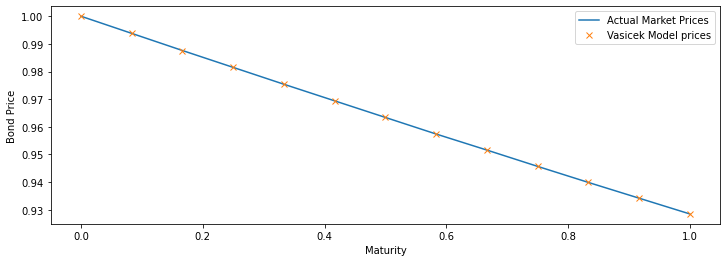

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t, market_zcb_prices, label='Actual Market Prices')
ax.plot(t, model_prices, 'x', label='Vasicek Model prices')
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.legend()
plt.show()

We calculate forward rates based on prices of zero-coupon bonds.

### Simulate LIBOR rate paths

We first initialize the parameter <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>&#x3C3;</mi>
    <mi>j</mi>
  </msub>
</math>

In [10]:
sigmaj = 0.2

We use paramters we obtained above to recreate the Vasicek bond prices:

In [11]:
def A(t1, t2):
    return (1 - np.exp(-opt_alpha * (t2-t1)))/opt_alpha

def C(t1, t2):
    val1 = (t2 - t1 - A(t1,t2)) * (opt_sigma**2/ (2 * opt_alpha**2) - opt_b)
    val2 = opt_sigma**2 * A(t1,t2)**2 / (4 * opt_alpha)
    return val1 - val2

def bond_price(r,t,T):
    return np.exp( -A(t,T)*r + C(t,T))

vasi_bond = bond_price(opt_r0, 0, t)

The prices calculated from the Vasicek model are close to the ZCB prices given by the assignment as shown below :

In [12]:
print("Model zero coupon bond prices: ", vasi_bond)
print("Market zero coupon bond prices: ", market_zcb_prices)

Model zero coupon bond prices:  [1.         0.99377572 0.98760087 0.98147516 0.97539831 0.96936998
 0.96338983 0.95745752 0.95157266 0.94573489 0.93994381 0.93419901
 0.9285001 ]
Market zero coupon bond prices:  [1.     0.9938 0.9876 0.9815 0.9754 0.9694 0.9634 0.9574 0.9516 0.9457
 0.9399 0.9342 0.9285]


We now initialize the matrices we will use to store the Monte Carlo simulations, for both basic Monte Carlo and Predictor-Corrector method.

In [13]:
n_simulations = sample_size
n_steps = len(t)

mc_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_capfac = np.ones([n_simulations, n_steps])
mc_capfac = np.ones([n_simulations, n_steps])

delta = np.ones([n_simulations, n_steps - 1])*(t[1:]-t[:-1])

We now run the Monte Carlo simulation for each time step:

In [14]:
for i in range(1, n_steps):
    Z = norm.rvs(size=[n_simulations,1])
    
    muhat = np.cumsum(delta[:, i:] * mc_forward[:, i:] * sigmaj**2 \
                       /(1 + delta[:, i:] * mc_forward[:,i:]), axis=1)
    
    mc_forward[:,i:] = mc_forward[:,i:] * \
                            np.exp((muhat-sigmaj**2/2)*delta[:,i:]
                                       +sigmaj*np.sqrt(delta[:,i:]) * Z)
    
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2 \
                           /(1 + delta[:,i:] * predcorr_forward[:,i:]), axis=1)
    
    for_temp = predcorr_forward[:,i:] * \
                    np.exp((mu_initial - sigmaj**2 / 2) * delta[:,i:] \
                                  + sigmaj * np.sqrt(delta[:,i:]) * Z)
    
    mu_term = np.cumsum(delta[:,i:] * for_temp*sigmaj**2 \
                         /(1 + delta[:,i:] * for_temp), axis=1)
    
    predcorr_forward[:,i:] = predcorr_forward[:,i:] * \
                                np.exp((mu_initial + mu_term - sigmaj**2) * delta[:,i:]/2 \
                                                             + sigmaj * np.sqrt(delta[:,i:]) * Z)

Capitalization factors and bond prices are simulated using Monte Carlo simulation, later we plot them to compare with the Vasicek bond prices.



In [15]:
mc_capfac[:,1:] = np.cumprod(1 + mc_forward, axis=1)
predcorr_capfac[:,1:] = np.cumprod(1 + predcorr_forward, axis=1)

mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)

mc_final = np.mean(mc_price, axis=0)
predcorr_final = np.mean(predcorr_price, axis=0)
predcorr_final

array([1.        , 0.99377572, 0.98759968, 0.98147252, 0.97539419,
       0.96936684, 0.9633865 , 0.95745479, 0.95157133, 0.9457365 ,
       0.93994657, 0.93420477, 0.92850814])

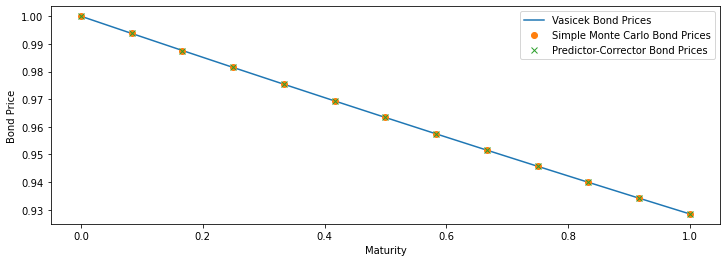

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t,vasi_bond, label="Vasicek Bond Prices")
ax.plot(t, mc_final, 'o', label="Simple Monte Carlo Bond Prices")
ax.plot(t, predcorr_final, 'x', label="Predictor-Corrector Bond Prices")

plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.legend()
plt.show()

In [17]:
model_forward_rates = (vasi_bond[:-1]-vasi_bond[1:])/ vasi_bond[1:]
pred_corr_forward_rates = np.mean(predcorr_forward, axis=0)

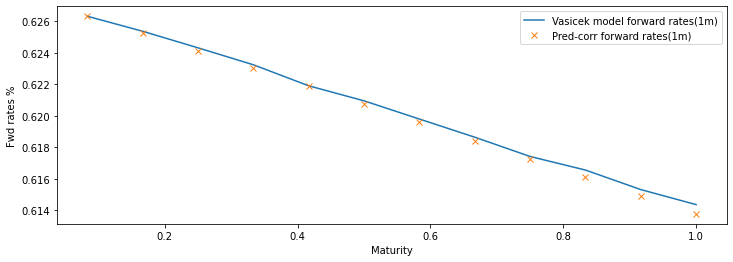

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t[1:], pred_corr_forward_rates * 100, label='Vasicek model forward rates(1m)')
ax.plot(t[1:], model_forward_rates * 100, 'x', label='Pred-corr forward rates(1m)')

plt.xlabel("Maturity")
plt.ylabel("Fwd rates %")
plt.legend()
plt.show()

We calculate continuous compounded interest rates using Predictor-Corrector method from simulated forward rates

$$e^{r_{ti}(t_{i+1}-t_{i})} = 1 + L(t_{i},t_{i+1})(t_{i+1}-t_{i})$$

In [19]:
r_sim = np.log(1 + predcorr_forward*(delta))/delta
r_sim

array([[0.00626163, 0.00608498, 0.00563556, ..., 0.00457335, 0.00459792,
        0.00451525],
       [0.00626163, 0.00629449, 0.00588518, ..., 0.0042358 , 0.00438515,
        0.00426602],
       [0.00626163, 0.0067545 , 0.00707255, ..., 0.00754074, 0.00741762,
        0.00754704],
       ...,
       [0.00626163, 0.00604921, 0.00632906, ..., 0.00489823, 0.00508931,
        0.00466497],
       [0.00626163, 0.00567469, 0.00497615, ..., 0.0058368 , 0.00560751,
        0.00545136],
       [0.00626163, 0.00627141, 0.00623676, ..., 0.00575536, 0.00587352,
        0.0050092 ]])

In [20]:
r_sim_annualized = pd.DataFrame(r_sim/delta)
r_sim_annualized

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.07514,0.073020,0.067627,0.070145,0.068056,0.067393,0.061118,0.058737,0.056885,0.054880,0.055175,0.054183
1,0.07514,0.075534,0.070622,0.074678,0.065657,0.065947,0.065816,0.063993,0.057165,0.050830,0.052622,0.051192
2,0.07514,0.081054,0.084871,0.084725,0.083505,0.088497,0.087554,0.088816,0.083829,0.090489,0.089011,0.090564
3,0.07514,0.065366,0.061753,0.060207,0.059367,0.061994,0.057168,0.058781,0.057707,0.054099,0.060110,0.064843
4,0.07514,0.076212,0.079009,0.080966,0.082937,0.082907,0.084241,0.083922,0.091366,0.088208,0.079161,0.084301
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.07514,0.068197,0.069929,0.070673,0.075729,0.069596,0.063990,0.064281,0.064033,0.063480,0.061069,0.057184
99996,0.07514,0.077469,0.079369,0.082186,0.083911,0.089083,0.075428,0.079390,0.083006,0.084104,0.087443,0.092025
99997,0.07514,0.072591,0.075949,0.070888,0.070954,0.068714,0.067305,0.067025,0.064145,0.058779,0.061072,0.055980
99998,0.07514,0.068096,0.059714,0.064255,0.058541,0.054210,0.054297,0.057810,0.069883,0.070042,0.067290,0.065416


## Generate stock and firm values

Cholesky decomposition will provide correlate price paths with predifined correlation factor.

In [21]:
def next_share_price(prev_price, r, dT, sigma_const, gamma, sample_size, Z, varying_vol = True):

    if varying_vol:
        sigma = sigma_const*(prev_price)**(gamma-1)
    else:
        sigma = sigma_const*(S0)**(gamma-1)
    
    return prev_price*np.exp(np.cumsum((r-(sigma**2)/2)*(dT)+(sigma)*(np.sqrt(dT))*Z,1))

def generate_share_and_firm_price(S0, v_0, r_sim, sigma_const, gamma, corr, T, sample_size, timesteps = 12):
    corr_matrix = np.array([[1, corr], [corr, 1]])
    norm_matrix = stats.norm.rvs(size = np.array([sample_size, 2, timesteps]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
    
    
    share_price_path = pd.DataFrame(
         next_share_price(S0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,0,]))
    share_price_path = share_price_path.transpose()
    
    first_row = pd.DataFrame([S0]*sample_size)
    first_row = first_row.transpose()
    share_price_path = pd.concat([first_row, share_price_path])
    share_price_path = share_price_path.reset_index(drop=True)

    firm_price_path = pd.DataFrame(
        next_share_price(v_0, r_sim, 1/timesteps, sigma_const, gamma, sample_size, Z=corr_norm_matrix[:,1,]))
    firm_price_path = firm_price_path.transpose()
    
    first_row = pd.DataFrame([v_0]*sample_size)
    first_row = first_row.transpose()
    firm_price_path = pd.concat([first_row, firm_price_path])
    firm_price_path = firm_price_path.reset_index(drop=True)

    return [share_price_path,firm_price_path]  

In [22]:
share_prices, firm_prices = generate_share_and_firm_price(S0, v_0, 
                                                          r_sim_annualized, 
                                                          sigma_const, 
                                                          gamma, 
                                                          corr, T, sample_size, timesteps = 12)

We then print out the share price and firm value paths:

In [23]:
share_prices

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,101.436602,101.038680,102.489508,100.754660,100.868925,101.219265,101.758504,101.897471,100.368648,98.237173,...,101.485892,95.751918,103.633938,104.028464,99.388479,99.911404,97.397276,101.913562,104.234317,99.228015
2,101.038194,106.505965,103.138396,100.512789,96.271263,98.054928,107.427231,104.620325,102.575113,103.472500,...,103.766279,97.245142,107.265355,104.405569,99.928864,100.345500,95.378216,102.822065,103.638552,99.537038
3,99.040427,108.223642,104.753492,98.387234,99.978016,100.309781,102.893818,103.752869,103.622768,107.078889,...,101.678678,99.389173,105.619884,110.260388,100.848431,103.640428,95.589783,102.131314,104.488579,101.755104
4,94.557265,107.601856,105.338823,98.480122,101.489962,103.803437,102.269591,108.318885,108.695082,104.951979,...,106.816575,102.133392,107.769036,112.463505,101.071196,107.442442,93.679307,107.558173,102.005051,98.153862
5,98.725127,110.047780,105.283529,96.577316,101.859694,107.624086,100.427025,106.574290,110.882554,103.124853,...,106.932566,100.823899,108.788163,117.990902,104.828393,110.851469,88.534769,111.543190,100.300833,97.293583
6,107.123718,107.622798,100.778195,93.100727,103.876138,114.091044,105.815200,111.754642,119.643227,98.404737,...,108.092940,97.589733,110.997173,124.980410,104.501266,113.349038,86.556392,112.867376,99.815738,100.234403
7,106.419959,107.156357,96.793017,93.412752,104.838251,116.543896,108.860298,106.364468,118.415940,98.586523,...,108.368857,97.674273,112.502740,122.724666,105.134101,113.293578,87.754743,119.427350,102.654372,97.252910
8,109.807344,105.870134,93.377932,92.013300,107.777391,117.776266,106.817312,109.108707,120.035379,95.762948,...,111.728853,98.453942,110.531987,122.830131,104.227335,118.099814,92.045274,119.218112,99.426261,91.868999
9,109.771518,108.744990,94.903897,94.702083,112.572123,123.537721,99.674736,107.697292,125.683353,97.647016,...,114.781785,98.715712,107.952408,120.926206,101.703472,115.086382,93.293038,122.458752,99.762193,94.829169


In [24]:
firm_prices

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
1,202.734344,203.937226,205.458428,198.447539,200.025013,205.394129,211.761070,200.528389,197.290149,188.006173,...,203.996151,205.853034,210.289736,194.767747,200.297038,208.513125,204.061546,207.047483,200.610499,205.651910
2,207.544817,206.097874,210.163964,200.163780,196.282574,205.142873,212.262397,208.180773,201.821160,191.778332,...,212.799288,212.344680,213.919317,194.584268,198.023787,211.242172,206.735913,213.770323,201.956106,207.270557
3,204.699662,206.647106,207.924770,198.992155,188.074399,207.874875,205.522193,207.032862,199.266658,198.307394,...,214.581131,206.475660,211.777915,200.963797,195.030943,220.756192,210.281414,208.296634,208.616420,209.959866
4,196.271817,209.036777,215.380568,213.326979,189.586931,206.580100,203.455446,207.294362,203.944507,196.227011,...,216.354550,208.025455,208.895852,198.102809,202.958794,217.372221,213.473921,205.795267,211.590757,210.932329
5,193.114799,211.305822,218.556729,218.435057,194.895175,217.807053,203.387747,210.208463,206.026439,202.003194,...,220.655379,205.979603,207.752581,198.786459,201.500909,220.051068,214.509073,209.845837,214.648133,213.230783
6,196.048725,212.870282,223.209358,205.617863,193.785625,212.123400,204.700939,214.925332,214.489256,206.242919,...,226.681516,204.001180,204.969331,201.547102,210.191770,229.931899,218.266835,212.262518,218.977138,217.554073
7,204.355838,206.270732,221.844595,205.500663,198.418366,214.178953,211.488144,209.850730,213.953071,209.333592,...,217.466449,194.346063,206.024200,201.885295,221.591484,237.567225,217.343369,215.348824,219.995503,214.646422
8,200.758023,210.993834,220.925112,205.605886,197.340462,220.954923,212.726295,207.033097,213.489643,210.179721,...,222.137402,203.822180,205.896565,198.712328,220.244443,244.328187,222.482905,219.988976,212.339597,211.969095
9,192.401874,217.851454,218.260324,210.038392,208.785981,220.438837,204.188350,218.963422,211.770955,220.077392,...,219.269518,205.086523,210.827869,191.586454,226.000788,234.456126,224.035047,222.497281,206.580319,207.418081


We also plot the first 1000 stock price and firm value paths simulated:

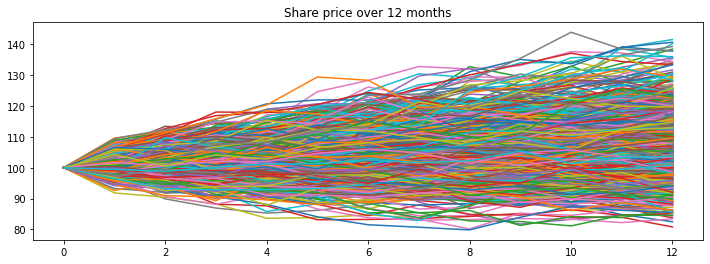

In [25]:
share_prices.iloc[:,0:1000].plot(
    title='Share price over 12 months', 
    legend=False,
    figsize=(12, 4));

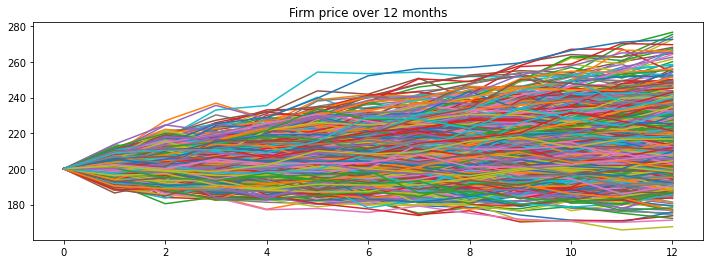

In [26]:
firm_prices.iloc[:,0:1000].plot(
    title='Firm price over 12 months', 
    legend=False,
    figsize=(12, 4));

# 2. Discount Factor and Value of the Up-and-Out Call Option

In this section we use the capitalisation factor calculated in the section above to obtain one-year discount factor. For each simulation - we build firm stock and firm price paths and resolve option payoff to get the final price.

We first calculated the one year discount factor, by inverting the capitalisation factor. The capitalisation factor is calculated by taking the cumulative product of the interest rate between each timestep.

In [27]:
one_year_disc_fac = 1/np.cumprod(1+r_sim,1)[:,-1]
print(one_year_disc_fac)

[0.9386054  0.93807457 0.91817599 ... 0.93501907 0.93842333 0.93212843]


Next, we calculate the default-free option value. \ One difference is that we multiple the payoff by the one year discount factor, instead of multiplying with  $e^{rT}$

In [28]:
# define payoff for up-and-out call option
def payoff(S_t, K, L):
    stopped_S = S_t.iloc[-1].where((S_t < L).all(), 0)
    return np.maximum(stopped_S - K, 0).to_numpy()

In [29]:
# Estimate the default-free value of the option:
option_estimate = []
option_std = []

payoffs = payoff(share_prices, K, L)
option_price = one_year_disc_fac*payoffs
print("Simulated option prices: %s" % option_price)
print("Simulated payoffs : %s" % payoffs)

Simulated option prices: [ 7.1504014   2.78125068  3.6133426  ... 29.72106462  5.29609436
  0.        ]
Simulated payoffs : [ 7.61811235  2.96485031  3.9353486  ... 31.78658653  5.64360898
  0.        ]


In [30]:
option_estimate = option_price.mean()
option_std = option_price.std()/np.sqrt(sample_size)

print("default-free option price: %.3f" % option_estimate)
print("default-free option price std: %.3f" % option_std)

default-free option price: 8.313
default-free option price std: 0.025


Next, we incorporate the CVA Adjustment similar to the first submission.

In [31]:
payoffs = payoff(share_prices, K, L)
term_firm_vals = firm_prices.iloc[-1].to_numpy()
amount_lost = one_year_disc_fac*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
cva_estimate = amount_lost.mean()
cva_std = amount_lost.std()/np.sqrt(sample_size)

option_cva_price = option_price - amount_lost
option_cva_adjusted_prices = option_cva_price.mean()
option_cva_adjusted_std = option_cva_price.std()/np.sqrt(sample_size)

In [32]:
print("Credit value adjustment: %.3f" % cva_estimate)
print("Credit value adjustment std: %.3f" % cva_std)
print("CVA-adjusted option price: %.3f" % option_cva_adjusted_prices)
print("CVA-adjusted option price std: %.3f" % option_cva_adjusted_std)

Credit value adjustment: 0.018
Credit value adjustment std: 0.001
CVA-adjusted option price: 8.295
CVA-adjusted option price std: 0.025


In [34]:
option_cva_adjusted_prices = []
option_cva_adjusted_std = []

for sample_size, paths in share_price_paths.items(): 
    payoffs = payoff(paths, K, L)
    option_price = np.exp(-risk_free*T)*payoffs

    term_firm_vals = firm_val_paths[sample_size].iloc[-1].to_numpy()
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_vals < debt)*payoffs
    
    option_cva_price = option_price - amount_lost
    
    option_cva_adjusted_prices.append(option_cva_price.mean())
    option_cva_adjusted_std.append(option_cva_price.std()/np.sqrt(sample_size))

NameError: name 'share_price_paths' is not defined

## 3 If you bought the option (rather than sold it), how does your own credit risk affect the value of the option?

We will calculate the difference between the CVA-adjusted option price and the default-free option price

In [33]:
val=option_estimate - 8.274
print("option price: %.3f" % val )

option price: 0.039


## 4 Suppose interest rates increased 25 basis points. What is the new value of your option? 

In [34]:
val += (val*25/100)+8.274
print("new value of your option: %.3f" % val )

new value of your option: 8.323
